In [1]:
!pip install pybullet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.5/80.5 MB 4.3 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for pybullet: filename=pybullet-3.2.6-cp311-cp311-macosx_10_9_x86_64.whl size=68419145 sha256=d21f11589556fc36f6c4302d4b2bec389a3ecc9694ffaf296aaffa799d59f832
  Stored in directory: /Users/carloslopez/Library/Caches/pip/wheels/29/ee/ef/afb46a713feb63a299a9146e5c65d7370576749b5ad5270297
Successfully built pybullet


In [2]:
# imports
import pybullet as p
import numpy as np
from matplotlib import pyplot as plt

pybullet build time: Jun 19 2024 17:23:13


In [3]:
#setup the simulation
sim_id = p.connect(p.DIRECT)

In [5]:
# PyBullet has a lot of built-in data (e.g., robor models), so let's get access to it
import pybullet_data
p.setAdditionalSearchPath(pybullet_data.getDataPath())

In [6]:
# load up a robot and some environment objects!
p.resetSimulation()

plane_id=p.loadURDF('plane.urdf',
            physicsClientId=sim_id)
robot_id=p.loadURDF("kuka_iiwa/model.urdf",
            basePosition=[0,0,0],
            baseOrientation=p.getQuaternionFromEuler([0,0,0]),
            useFixedBase=True,
            physicsClientId=sim_id,
            globalScaling=1,
            flags=p.URDF_USE_IMPLICIT_CYLINDER)
cube_id=p.loadURDF('cube.urdf',
            basePosition=[0.5, 0, 0.5],
            physicsClientId=sim_id,
            globalScaling=0.2)
sphere_id=p.loadURDF('sphere2.urdf',
            basePosition=[0, 0.5, 0.5],
            physicsClientId=sim_id,
            globalScaling=0.2)
            
p.getNumBodies()

4

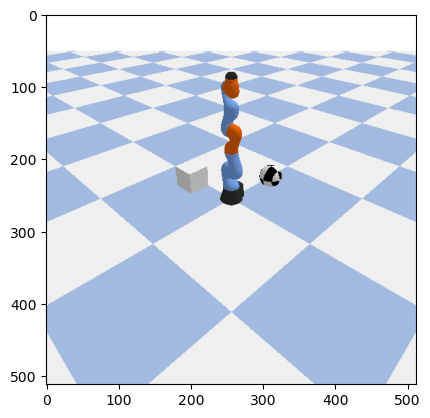

In [7]:
# We can inspect some images, as a sanity check:
def showImage(cameraPos=[2, 2, 2]):
  viewMatrix = p.computeViewMatrix(
              cameraEyePosition=cameraPos,
              cameraTargetPosition=[0, 0, 0],
              cameraUpVector=[0, 0, 1])
  projectionMatrix = p.computeProjectionMatrixFOV(
              fov=60.0,
              aspect=1.0,
              nearVal=0.1,
              farVal=10)
  width, height, rgbImg, depthImg, segImg = p.getCameraImage(
              width=512,
              height=512,
              viewMatrix=viewMatrix,
              projectionMatrix=projectionMatrix)
  plt.imshow(rgbImg)

showImage()

In [8]:
def is_collision():
  p.performCollisionDetection(physicsClientId=sim_id)
  all_contact_points = [cp for cp in p.getContactPoints(bodyA=robot_id) \
                        if cp[1] != plane_id and cp[2] != plane_id and cp[8] < 0]
  # cp[1] is first collision object, cp[2] is second collision object
  # cp[8] is collision distance, where NEGATIVE value indicates penetration (pos value is separation)
  return len(all_contact_points) > 0

In [9]:
def move_end_effector(target_pos):
  desired_angles = p.calculateInverseKinematics(robot_id, p.getNumJoints(robot_id) - 1, target_pos)
  for i in range(p.getNumJoints(robot_id)):
    p.resetJointState(robot_id, i, desired_angles[i])

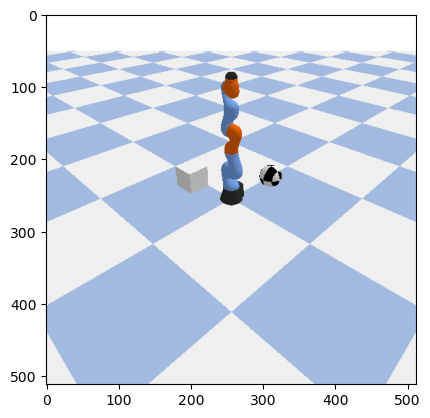

In [10]:
# make robot touch ball
move_end_effector([0, 0.5, 0.5])
showImage()

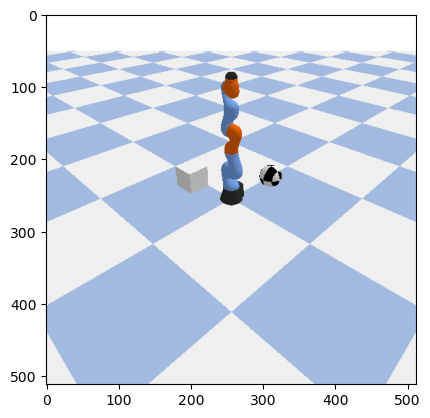

In [11]:
for i in range(p.getNumJoints(robot_id)):
  p.resetJointState(robot_id, i, 0)
showImage()

In [12]:
#focus on the 0t and 1st joints
def setRobotPos(theta0, theta1):
  if abs(theta0) > np.pi * 3 / 4:
    raise ValueError(f'{theta0} out of bounds for theta0')
  if abs(theta1 ) > np.pi * 2 / 3:
    raise ValueError(f'{theta1} out of bounds for theta1')
  p.resetJointState(robot_id, 0, theta0)
  p.resetJointState(robot_id, 1, theta1)

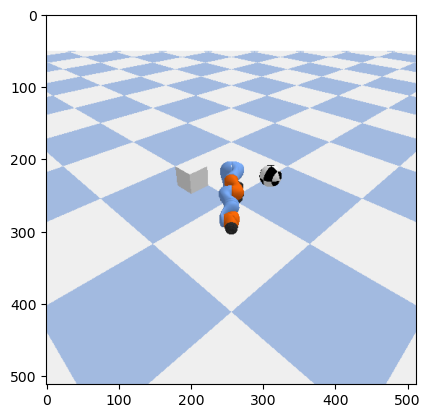

In [13]:
#look it points at you =O!!!
setRobotPos(np.pi/4, np.pi*1/2)
showImage()

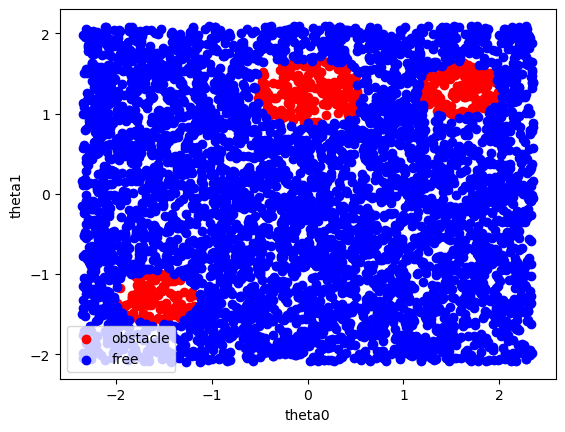

In [14]:
def flattened_cspace(num_samples):
  obs_space = list()
  free_space = list()
  for i in range(num_samples):
    theta0 = (np.pi * 3 / 4) * 2 * (np.random.random() - 0.5)
    theta1 = (np.pi * 2 / 3) * 2 * (np.random.random() - 0.5)
    setRobotPos(theta0, theta1)
    if is_collision():
      obs_space.append([theta0, theta1])
    else:
      free_space.append([theta0, theta1])
    
  plt.scatter(x = [item[0] for item in obs_space], y=[item[1] for item in obs_space], color='r', label='obstacle')
  plt.scatter(x = [item[0] for item in free_space], y=[item[1] for item in free_space], color='b', label='free')
  plt.xlabel('theta0')
  plt.ylabel('theta1')
  plt.legend()
  plt.show()      

flattened_cspace(5000)

In [15]:
def convert_thetas_to_torus(angles, large_ring_radius=0.7, small_ring_radius=0.2):
  xs = list()
  ys = list()
  zs = list()
  for theta_pair in angles:
    theta0, theta1 = theta_pair[0], theta_pair[1]

    large_ring_x = large_ring_radius * np.cos(theta0)
    large_ring_y = large_ring_radius * np.sin(theta0)

    small_ring_xy = np.cos(theta1) * small_ring_radius
    small_ring_z = np.sin(theta1) * small_ring_radius

    small_ring_x = np.cos(theta0) * small_ring_xy
    small_ring_y = np.sin(theta0) * small_ring_xy

    x = large_ring_x + small_ring_x
    y = large_ring_y + small_ring_y
    z = small_ring_z

    xs.append(x)
    ys.append(y)
    zs.append(z)

  return xs, ys, zs

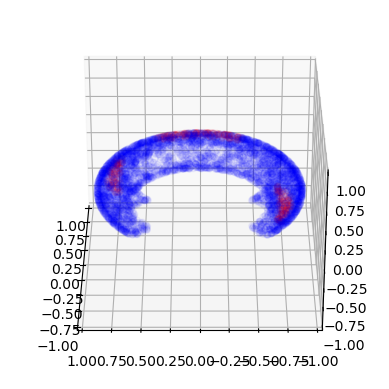

In [18]:
def cspace(num_samples):
  obs_space = list()
  free_space = list()
  for i in range(num_samples):
    theta0 = (np.pi * 3 / 4) * 2 * (np.random.random() - 0.5)
    theta1 = (np.pi * 2 / 3) * 2 * (np.random.random() - 0.5)
    setRobotPos(theta0, theta1)
    if is_collision():
      obs_space.append([theta0, theta1])
    else:
      free_space.append([theta0, theta1])
      
  ax = plt.figure().add_subplot(projection='3d')
  xs, ys, zs = convert_thetas_to_torus(obs_space)
  ax.scatter(xs, ys, zs, color='r', alpha=0.07)
  xs, ys, zs = convert_thetas_to_torus(free_space)
  ax.scatter(xs, ys, zs, color='b', alpha=0.045)
  ax.set_xlim([-1, 1])
  ax.set_ylim([-1, 1])
  ax.set_zlim([-1, 1])
  ax.view_init(elev=30, azim=180, roll=0)
  plt.show()

cspace(5000)